# **Sentiment Analysis**

# Description

La détection des émotions à partir d’un texte est l’un des problèmes difficiles du NLP. La raison est due à l’indisponibilité d’un ensemble de données labelisés et la nature multiclasse du problème. Les humains ont une variété d’émotions et il est difficile de collecter suffisamment d’enregistrements pour chaque émotion, d’où le problème du déséquilibre des classes.

# Features

1. `Text` - Les données textuelles fournies sur lesquelles les données doivent être formées et testées

2. `Emotion` - L'émotion qui y est associée

# Importing libraries

In [21]:
# %pip install -q hvplot

In [22]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hvplot.pandas
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings

nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

sns.set(font_scale=1.3)
nltk.download('omw-1.4')

from wordcloud import WordCloud, STOPWORDS
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [23]:
# Load data
df_train = pd.read_csv('train.txt', names=['Text', 'Emotion'], sep=';')
df_val = pd.read_csv('val.txt', names=['Text', 'Emotion'], sep=';')
df_test = pd.read_csv('test.txt', names=['Text', 'Emotion'], sep=';')

In [24]:
df_train.head(), df_train.shape

(                                                Text  Emotion
 0                            i didnt feel humiliated  sadness
 1  i can go from feeling so hopeless to so damned...  sadness
 2   im grabbing a minute to post i feel greedy wrong    anger
 3  i am ever feeling nostalgic about the fireplac...     love
 4                               i am feeling grouchy    anger,
 (16000, 2))

In [25]:
df_test.head(), df_test.shape

(                                                Text  Emotion
 0  im feeling rather rotten so im not very ambiti...  sadness
 1          im updating my blog because i feel shitty  sadness
 2  i never make her separate from me because i do...  sadness
 3  i left with my bouquet of red and yellow tulip...      joy
 4    i was feeling a little vain when i did this one  sadness,
 (2000, 2))

In [26]:
df_val.head(), df_val.shape

(                                                Text  Emotion
 0  im feeling quite sad and sorry for myself but ...  sadness
 1  i feel like i am still looking at a blank canv...  sadness
 2                     i feel like a faithful servant     love
 3                  i am just feeling cranky and blue    anger
 4  i can have for a treat or if i am feeling festive      joy,
 (2000, 2))

# Pre-processing

## Check of dataset

### Train dataset

In [27]:
# vérifier si les données sont équilibrées ou non
df_train.Emotion.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: Emotion, dtype: int64

In [28]:
df_train.Emotion.value_counts() / df_train.shape[0] *100

joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: Emotion, dtype: float64

Les données sont déséquilibrées donc nous pouvons essayer de les équilibrer mais aussi, les émotions qui nous intéressent sont les émotions les plus répétées donc, jusqu'à présent, nous pouvons garder les données telles quelles.

In [29]:
# afficher le nombre de valeurs nulles dans chaque colonne
df_train.isnull().sum()

Text       0
Emotion    0
dtype: int64

Le dataset n'a pas de valeurs null.

In [30]:
# afficher le nombre de valeurs dupliquées
df_train.duplicated().sum()

1

Il n'y a qu'une seule ligne qui est dupliquée mais nous devons également vérifier s'il y a des lignes ayant le même texte mais des émotions différentes

In [31]:
# supprimer les valeurs dupliquées
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [32]:
# afficher les lignes qui sont dupliquées (dupliquées dans le texte mais avec des émotions différentes)
df_train[df_train['Text'].duplicated() == True]

Text   Emotion
5067   i feel on the verge of tears from weariness i ...       joy
6133               i still feel a craving for sweet food      love
6563   i tend to stop breathing when i m feeling stre...     anger
7623   i was intensely conscious of how much cash i h...   sadness
7685   im still not sure why reilly feels the need to...  surprise
8246   i am not amazing or great at photography but i...      love
9596   ive also made it with both sugar measurements ...       joy
9687   i had to choose the sleek and smoother feel of...       joy
9769   i often find myself feeling assaulted by a mul...   sadness
9786        i feel im being generous with that statement       joy
10117  i feel pretty tortured because i work a job an...      fear
10581                       i feel most passionate about       joy
11273  i was so stubborn and that it took you getting...       joy
11354  i write these words i feel sweet baby kicks fr...      love
11525  i feel a remembrance of the strange by justin ...      fear
11823  i have chose for myself that makes me feel ama...       joy
12441                   i still feel completely accepted      love
12562                           i feel so weird about it  surprise
12892  i cant escape the tears of sadness and just tr...       joy
13236   i feel like a tortured artist when i talk to her     anger
13879  i feel like i am very passionate about youtube...      love
14106                             i feel kind of strange  surprise
14313    i could feel myself hit this strange foggy wall  surprise
14633  i feel pretty weird blogging about deodorant b...      fear
14925  i resorted to yesterday the post peak day of i...      fear
15314  i will feel as though i am accepted by as well...       joy
15328  i shy away from songs that talk about how i fe...       joy
15571  i bet taylor swift basks in the knowledge that...     anger
15704  i began to feel accepted by gaia on her own terms       joy
15875  i was sitting in the corner stewing in my own ...     anger

In [33]:
# check un text dupliqué
df_train[df_train['Text'] == df_train.iloc[6133]['Text']]

Text Emotion
4476  i still feel a craving for sweet food     joy
6133  i still feel a craving for sweet food    love

In [34]:
# supprimer les text dupliquées
index = df_train[df_train['Text'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [35]:
# compter le nombre de stop words dans le dataset
temp =df_train.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: stop_words, dtype: int64

Les données contiennent beaucoup de stopwords (certaines lignes en contiennent plus de 25), nous devons donc faire attention lorsque nous les supprimons car certaines lignes peuvent devenir vides.

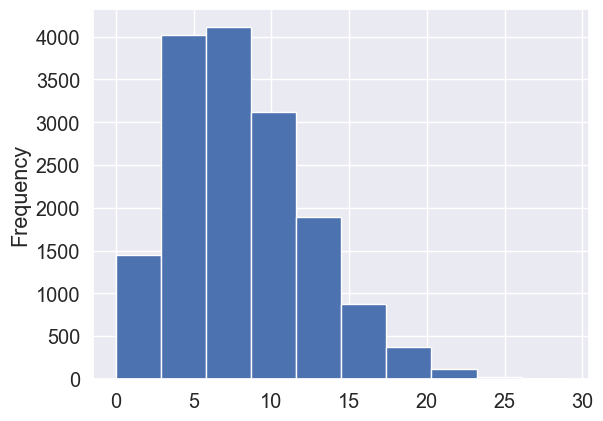

In [36]:
# distribution des stop words
temp['stop_words'].plot(kind= 'hist')
plt.show()

Voici une distribution du nombre de stopwords, on peut voir que la plupart des lignes contiennent moins de 10 stopwords (entre 5 et 10).

In [37]:
def plotting(df):
    col = 'Emotion'
    fig, (ax1, ax2)  = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    explode = list((np.array(list(df[col].dropna().value_counts()))/sum(list(df[col].dropna().value_counts())))[::-1])
    sizes = df[col].value_counts()
    labels = sizes.index
    ax2.pie(sizes,  explode=explode, startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.9)
    ax2.add_artist(plt.Circle((0,0),0.6,fc='white'))
    sns.countplot(x =col, data = df, ax=ax1)
    ax1.set_title("Nombre de chaque émotion")
    ax2.set_title("Pourcentage de chaque émotion")
    plt.show()

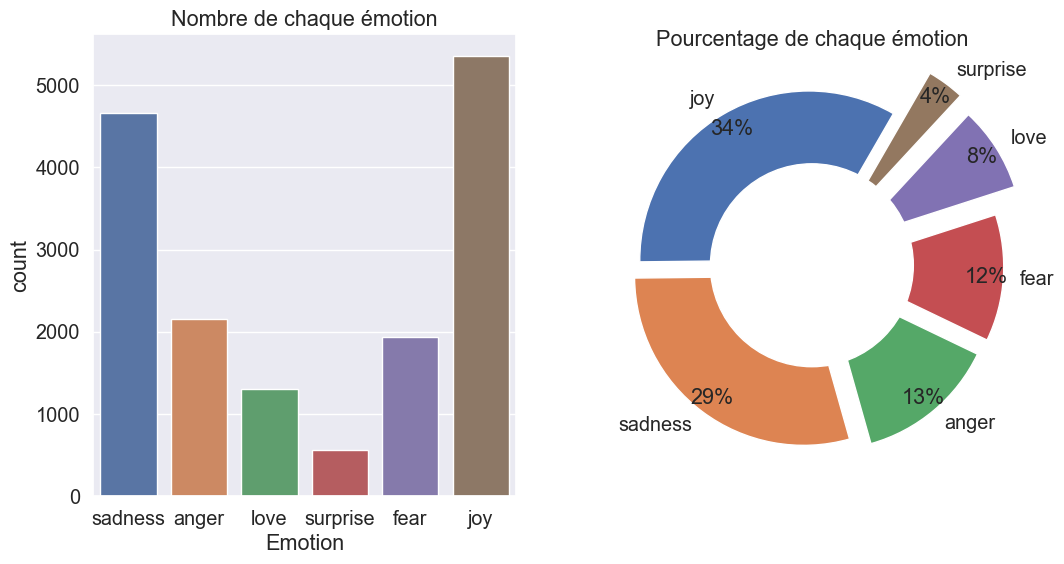

In [38]:
plotting(df_train)

On peut voir que les émotions les plus répétées sont `sadness` et `joy`.

In [39]:
def wordcloud(df, emotion):
    text = " ".join(review for review in df[df['Emotion'] == emotion]['Text'])
    stopwords = set(STOPWORDS)
    stopwords.update(["br", "href"])
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(emotion)
    plt.show()

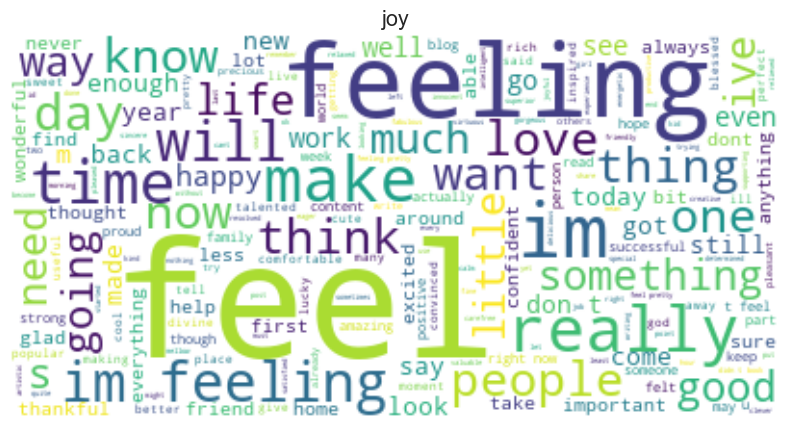

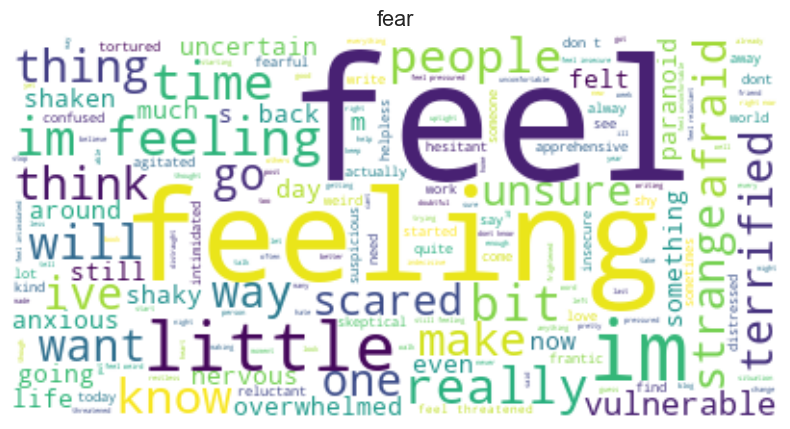

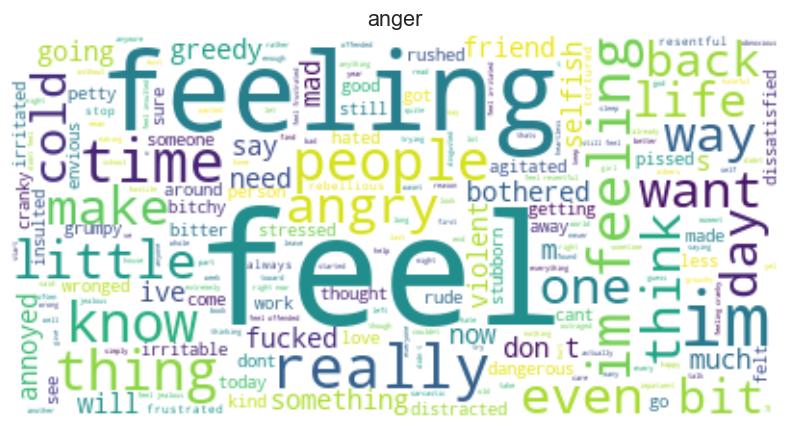

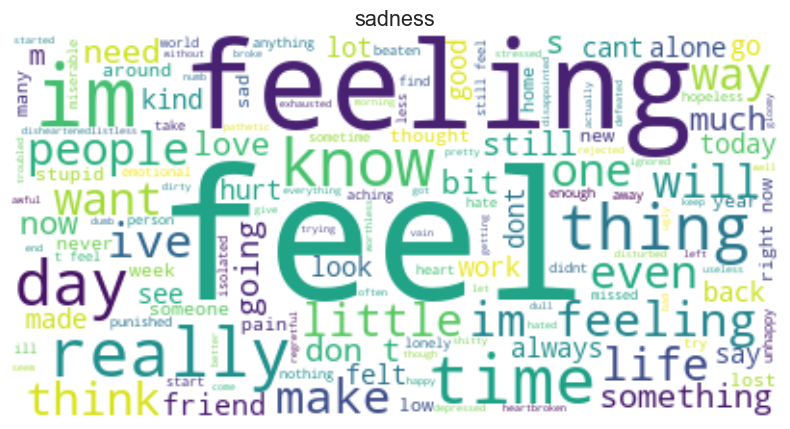

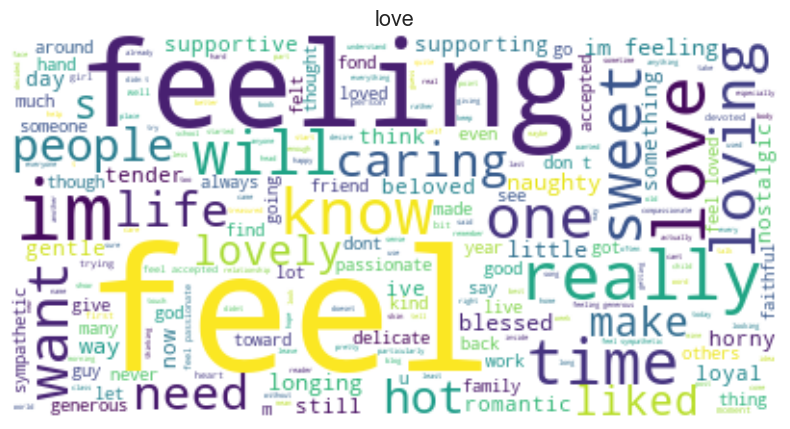

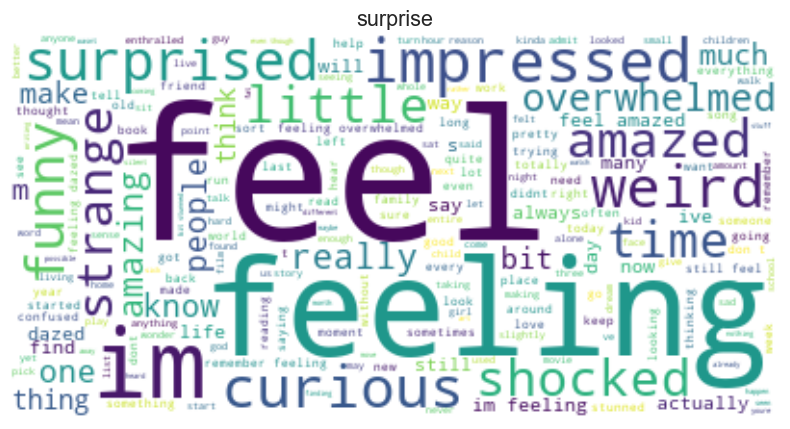

In [40]:
wordcloud(df_train, 'joy')
wordcloud(df_train, 'fear')
wordcloud(df_train, 'anger')
wordcloud(df_train, 'sadness')
wordcloud(df_train, 'love')
wordcloud(df_train, 'surprise')

On peut remarquer que malgrè les différentes émotions, la plupart des mots les plus fréquents sont les mêmes.
Ce qui veut dire que les mots les plus fréquents ne sont pas spécifiques à une émotion.

### Test dataset

On va faire les mêmes vérifications que pour le train dataset sur le test dataset.

In [41]:
df_test.Emotion.value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: Emotion, dtype: int64

In [42]:
df_test.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [43]:
df_test.duplicated().sum()

0

In [44]:
df_test[df_test['Text'].duplicated() == True]

Empty DataFrame
Columns: [Text, Emotion]
Index: []

In [45]:
temp =df_test.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()


7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: stop_words, dtype: int64

<AxesSubplot:ylabel='Frequency'>

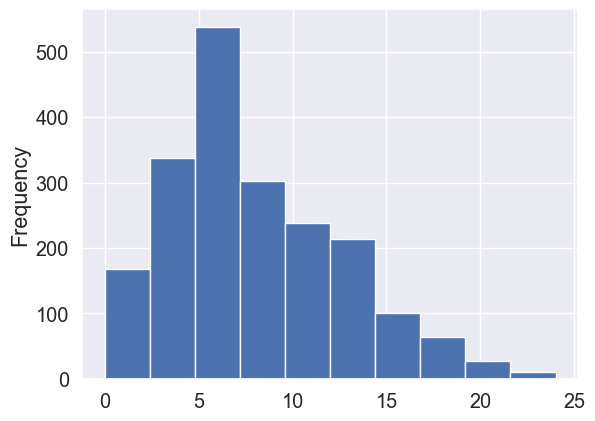

In [46]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

On peut voir que la plupart des lignes contiennent entre 4 et 7 stopwords.

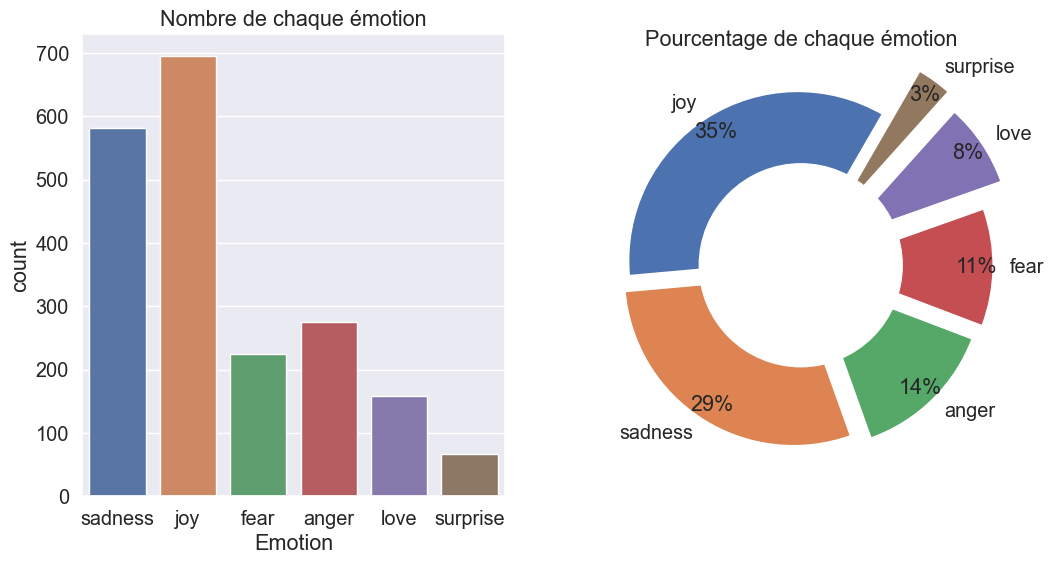

In [47]:
plotting(df_test)

C'est la même chose pour le test dataset, les émotions les plus répétées sont `sadness` et `joy`.

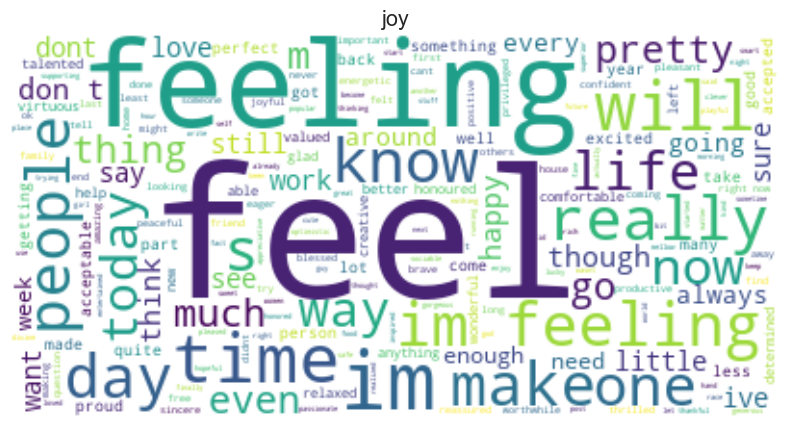

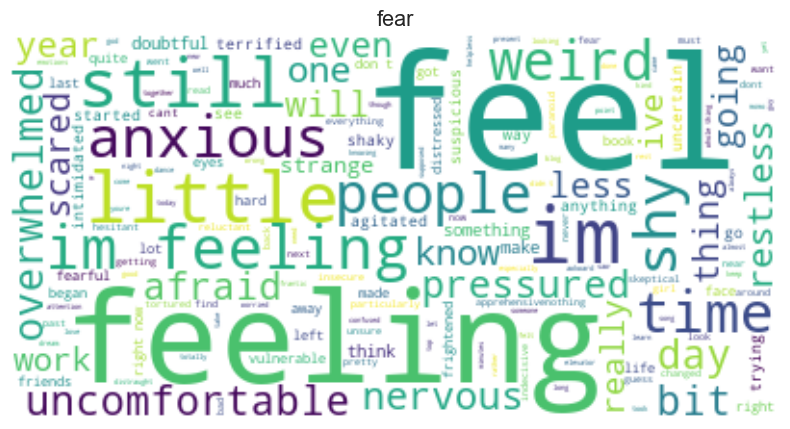

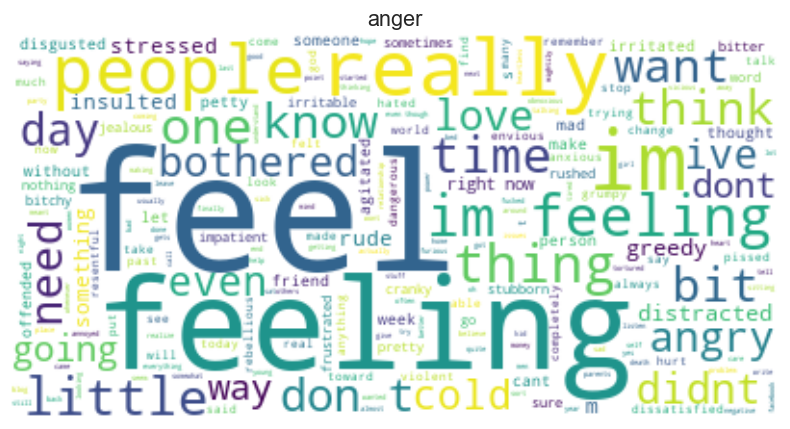

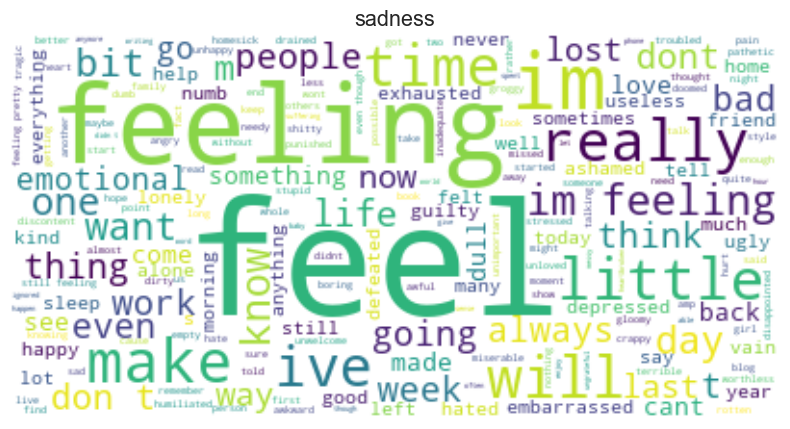

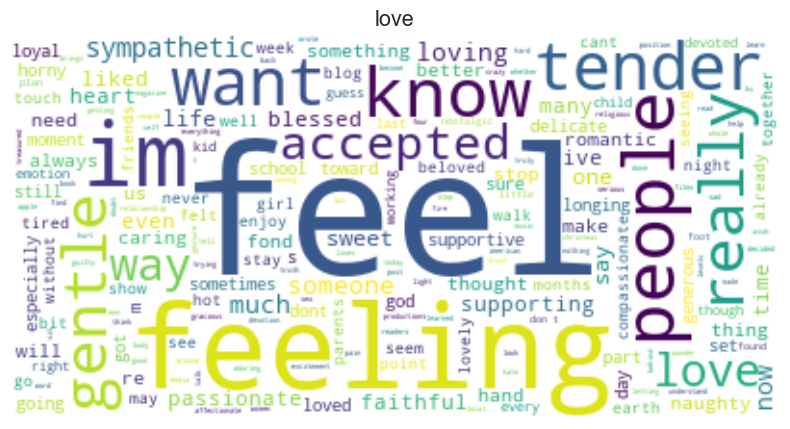

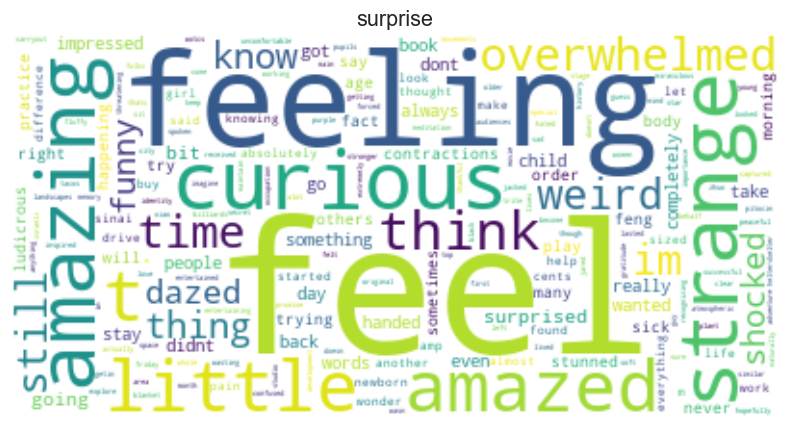

In [48]:
wordcloud(df_test, 'joy')
wordcloud(df_test, 'fear')
wordcloud(df_test, 'anger')
wordcloud(df_test, 'sadness')
wordcloud(df_test, 'love')
wordcloud(df_test, 'surprise')

On peut remarquer que malgrè les différentes émotions, la plupart des mots les plus fréquents sont les mêmes.
Mais comparé au train dataset, les mots les plus fréquents sont différents.

### Validation dataset

On va faire les mêmes vérifications que pour le train et le test dataset sur le val dataset.

In [49]:
df_val.Emotion.value_counts()

joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: Emotion, dtype: int64

In [50]:
df_val.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [51]:
df_val.duplicated().sum()

0

In [52]:
df_val[df_val['Text'].duplicated() == True]

Text Emotion
603   i have had several new members tell me how com...     joy
1993                           i feel so tortured by it   anger

In [53]:
df_val[df_val['Text'] == df_val.iloc[603]['Text']]

Text Emotion
300  i have had several new members tell me how com...    love
603  i have had several new members tell me how com...     joy

In [54]:
df_val[df_val['Text'] == df_val.iloc[1993]['Text']]

Text Emotion
774   i feel so tortured by it    fear
1993  i feel so tortured by it   anger

In [55]:
index = df_val[df_val['Text'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [56]:
temp =df_val.copy()
temp['stop_words'] = temp['Text'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()


7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
12     76
13     74
1      64
14     63
15     44
16     36
17     31
18     21
19     16
20     16
0      11
21      6
22      3
23      2
Name: stop_words, dtype: int64

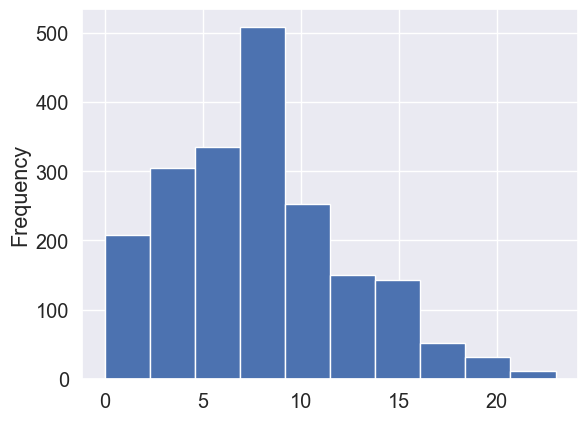

In [57]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

On remarque cette fois-ci que la plupart des lignes contiennent entre 6 et 8 stopwords.

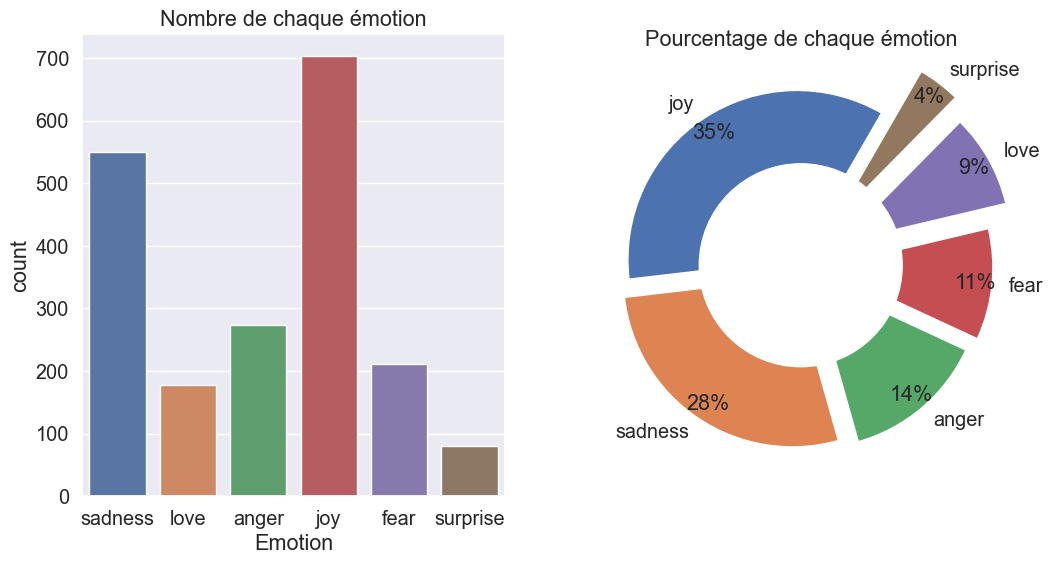

In [58]:
plotting(df_val)

C'est la même chose pour le val dataset, les émotions les plus répétées sont `sadness` et `joy`.

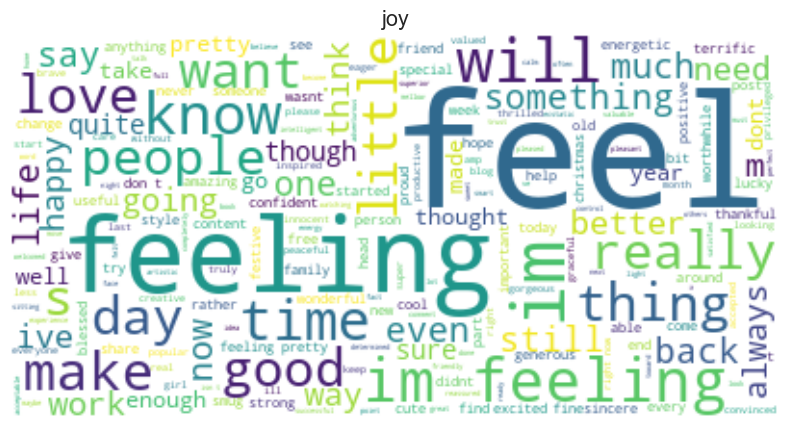

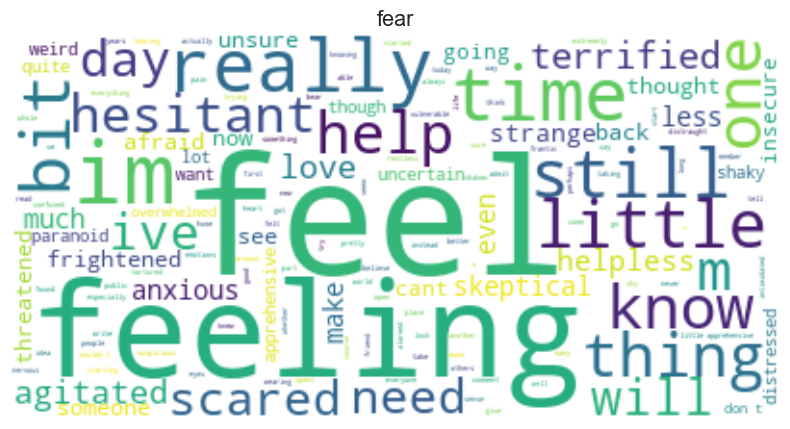

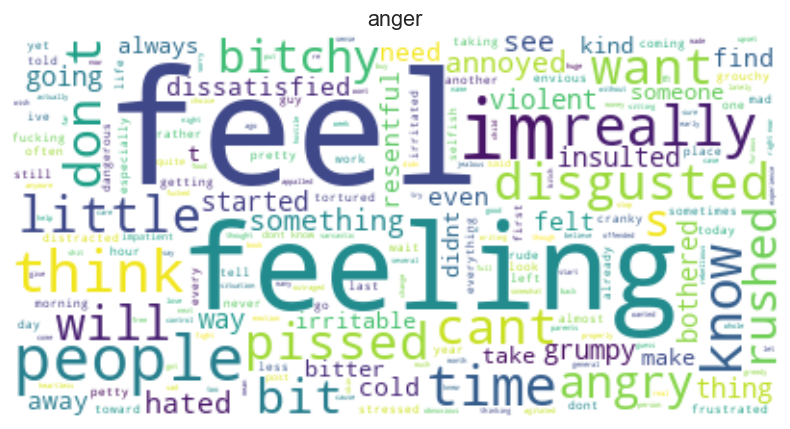

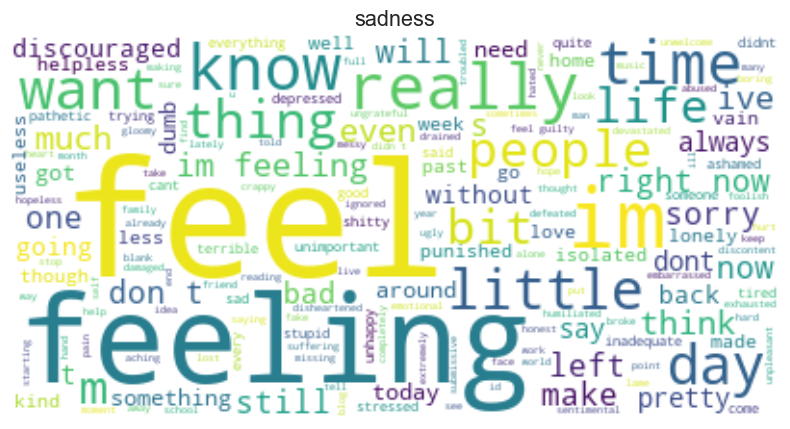

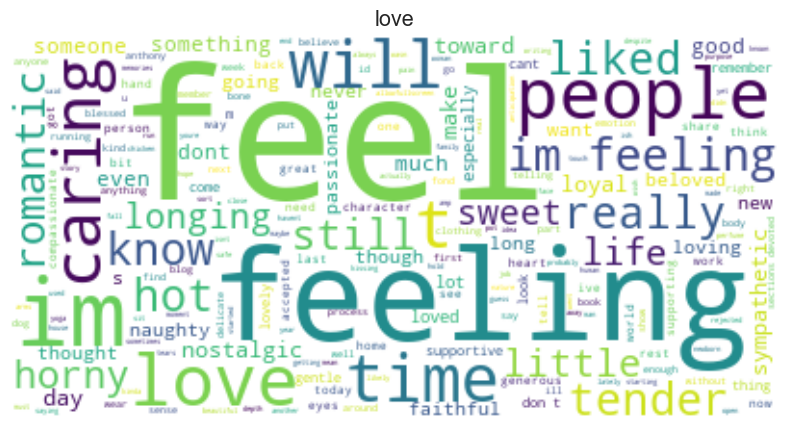

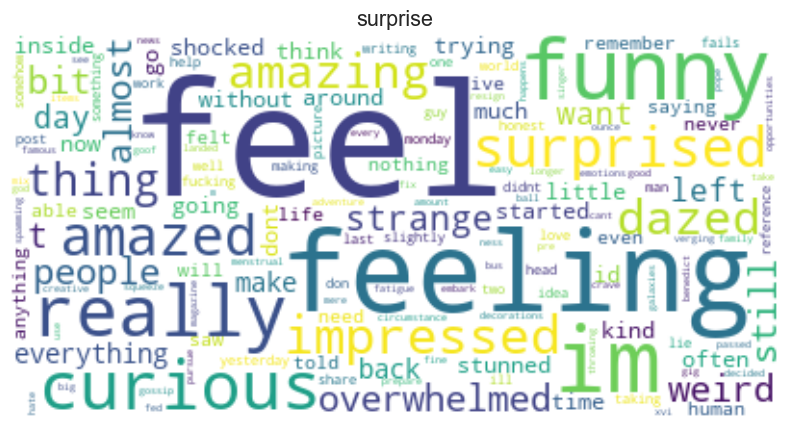

In [59]:
wordcloud(df_val, 'joy')
wordcloud(df_val, 'fear')
wordcloud(df_val, 'anger')
wordcloud(df_val, 'sadness')
wordcloud(df_val, 'love')
wordcloud(df_val, 'surprise')

On peut remarquer que malgrè les différentes émotions, la plupart des mots les plus fréquents sont les mêmes.
Mais comparé au train dataset, les mots les plus fréquents sont différents.

## Comparaison des datasets

In [60]:
def dataframe_difference(df1, df2, which=None):
    comparison_df = df1.merge(
        df2,
        indicator=True,
        how='outer'
    )
    
    if which is None:
        diff_df = comparison_df[comparison_df['_merge'] != 'both']
    else:
        diff_df = comparison_df[comparison_df['_merge'] == which]
        
    return diff_df

In [61]:
dataframe_difference(df_train, df_test, which='both')

Empty DataFrame
Columns: [Text, Emotion, _merge]
Index: []

In [62]:
dataframe_difference(df_train, df_val, which='both')

Empty DataFrame
Columns: [Text, Emotion, _merge]
Index: []

In [63]:
dataframe_difference(df_val, df_test, which='both')

Empty DataFrame
Columns: [Text, Emotion, _merge]
Index: []

Il n'y a aucune différence entre les datasets.

# Cleaning

Nous allons maintenant nettoyer les données en supprimant les stopwords, les caractères spéciaux, les nombres, la ponctuaction et en lemmatisant les mots.

In [64]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()
    text = text.split()
    text=[lemmatizer.lemmatize(y) for y in text]
    return " " .join(text)

def remove_stop_words(text):
    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    text = text.split()
    text=[y.lower() for y in text]
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    df.Text=df.Text.apply(lambda text : lower_case(text))
    df.Text=df.Text.apply(lambda text : remove_stop_words(text))
    df.Text=df.Text.apply(lambda text : Removing_numbers(text))
    df.Text=df.Text.apply(lambda text : Removing_punctuations(text))
    df.Text=df.Text.apply(lambda text : Removing_urls(text))
    df.Text=df.Text.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [65]:
print('Avant Text prerocessing et normalizing')
display(df_train.head()[['Text']])
display(df_test.head()[['Text']])
display(df_val.head()[['Text']])
print('Après Text prerocessing et normalizing')
df_train= normalize_text(df_train)
df_test= normalize_text(df_test)
df_val= normalize_text(df_val)
display(df_train.head()[['Text']])
display(df_test.head()[['Text']])
display(df_val.head()[['Text']])

Avant Text prerocessing et normalizing


Text
0                            i didnt feel humiliated
1  i can go from feeling so hopeless to so damned...
2   im grabbing a minute to post i feel greedy wrong
3  i am ever feeling nostalgic about the fireplac...
4                               i am feeling grouchy

Text
0  im feeling rather rotten so im not very ambiti...
1          im updating my blog because i feel shitty
2  i never make her separate from me because i do...
3  i left with my bouquet of red and yellow tulip...
4    i was feeling a little vain when i did this one

Text
0  im feeling quite sad and sorry for myself but ...
1  i feel like i am still looking at a blank canv...
2                     i feel like a faithful servant
3                  i am just feeling cranky and blue
4  i can have for a treat or if i am feeling festive

Après Text prerocessing et normalizing


Text
0                              didnt feel humiliated
1  go feeling hopeless damned hopeful around some...
2          im grabbing minute post feel greedy wrong
3  ever feeling nostalgic fireplace know still pr...
4                                    feeling grouchy

Text
0        im feeling rather rotten im ambitious right
1                       im updating blog feel shitty
2    never make separate ever want feel like ashamed
3  left bouquet red yellow tulip arm feeling slig...
4                            feeling little vain one

Text
0           im feeling quite sad sorry ill snap soon
1  feel like still looking blank canvas blank pie...
2                         feel like faithful servant
3                                feeling cranky blue
4                              treat feeling festive

# Modeling

Étudions en profondeur les émotions et le texte qui y est associé.

In [66]:
def char_length(df):
    df['char_length'] = df['Text'].apply(lambda x : len(x))
    fig, ax = plt.subplots(figsize=(16,8))
    for emotion in df['Emotion'].value_counts().sort_values().index.tolist():
        sns.kdeplot(df[df['Emotion'] == emotion]['char_length'],ax=ax, label=emotion)
    ax.legend()
    ax.set_title("Répartition de la longueur des caractères en termes d'émotion")
    plt.show()

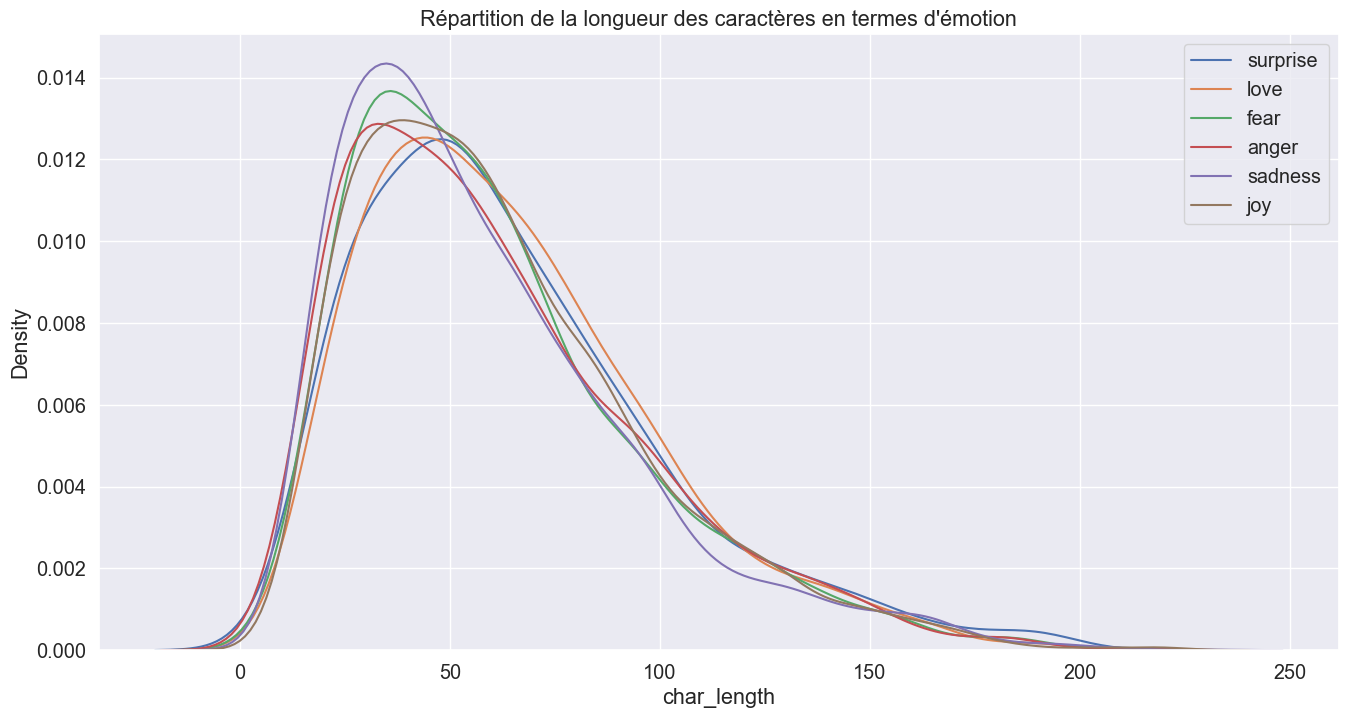

In [67]:
char_length(df_train)

On peut voir que pour toutes les émotions, la longueur moyenne du texte est d'environ 50 caractères.
Ce qui veut dire que la longueur du texte n'est pas un facteur important pour déterminer l'émotion.

In [68]:
def token_length(df):
    df['token_length'] = df['Text'].apply(lambda x : len(x.split(" ")))
    fig, ax = plt.subplots(figsize=(16,8))
    for emotion in df['Emotion'].value_counts().sort_values().index.tolist():
        sns.kdeplot(df[df['Emotion'] == emotion]['token_length'],ax=ax, label=emotion)
    ax.legend()
    ax.set_title("Répartition de la longueur du token en termes d'émotion")
    plt.show()

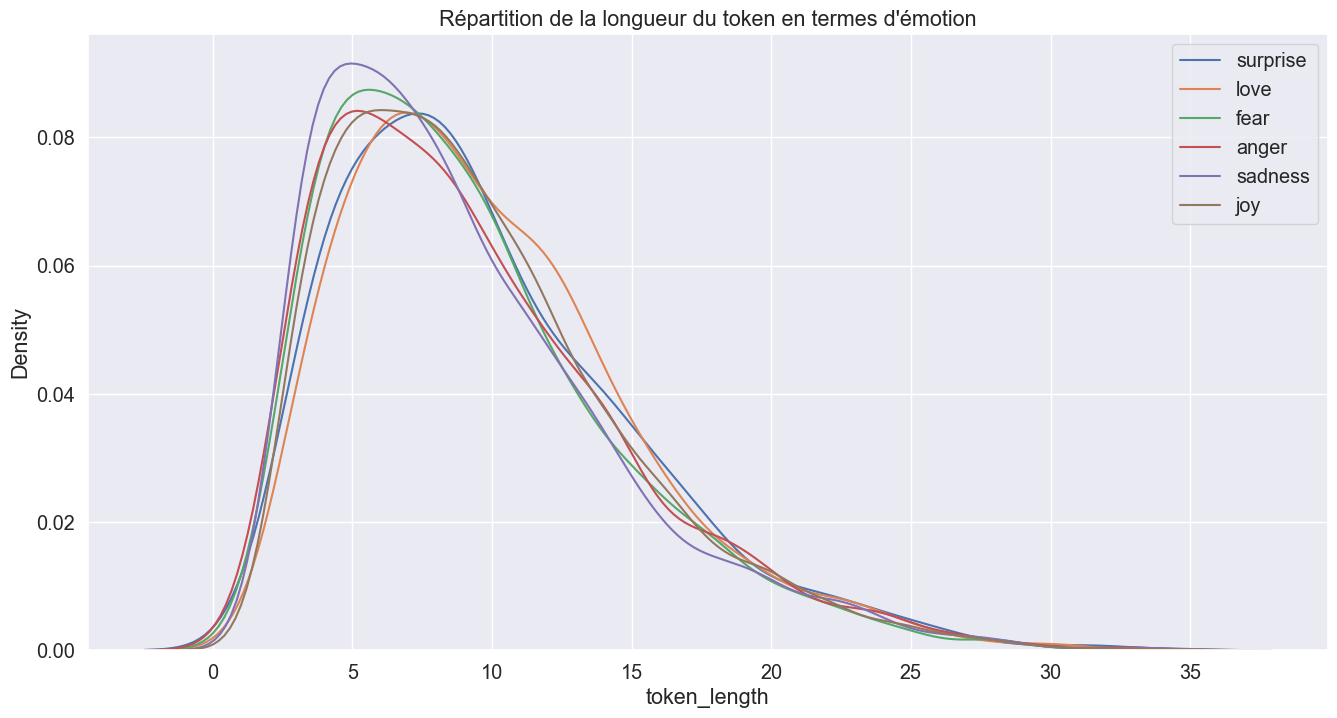

In [69]:
token_length(df_train)

On peut voir que pour toutes les émotions, la longueur moyenne des tokens est d'environ 5 caractères.
Ce qui veut dire que la longueur des tokens n'est pas un facteur important pour déterminer l'émotion.

In [70]:
from collections import defaultdict
def emotion_words(df, emotion):

    print("Nuage de mots des mots les plus fréquents pour le sentiment: {}".format(emotion))

    temp_df = df[df['Emotion']==emotion]
    print("Nombre de lignes : ", len(temp_df))

    msg = ''
    for text in temp_df.Text:
        text = str(text)
        msg += text
        
    total = 0
    count = defaultdict(lambda: 0)
    for word in msg.split(" "):
        total += 1
        count[word] += 1
        
    top20pairs = sorted(count.items(), key=lambda kv: kv[1], reverse=True)[:20]
    top20words = [i[0] for i in top20pairs]
    top20freq = [i[1] for i in top20pairs]
    
    xs = np.arange(len(top20words))
    width = 0.5

    fig = plt.figure(figsize=(10,6))                                                               
    ax = fig.gca()  #get current axes
    ax.bar(xs, top20freq, width, align='center')

    ax.set_xticks(xs)
    ax.set_xticklabels(top20words)
    plt.xticks(rotation=45)
    plt.show()
    
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(max_font_size=50, max_words=50,stopwords=stopwords, background_color="white").generate(msg)
    plt.figure(figsize = (12, 12), facecolor = None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Nuage de mots des mots les plus fréquents pour le sentiment: joy
Nombre de lignes :  5350


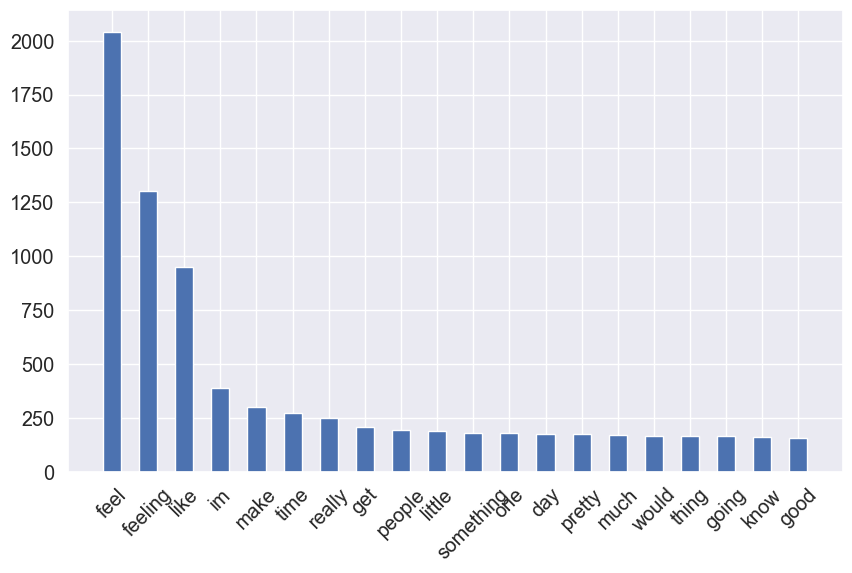

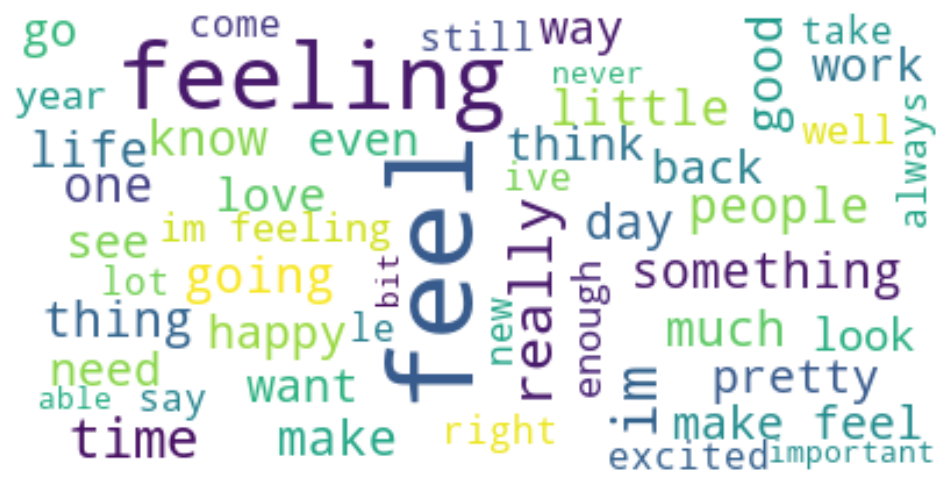

In [71]:
emotion_words(df_train, 'joy')

Nuage de mots des mots les plus fréquents pour le sentiment: surprise
Nombre de lignes :  568


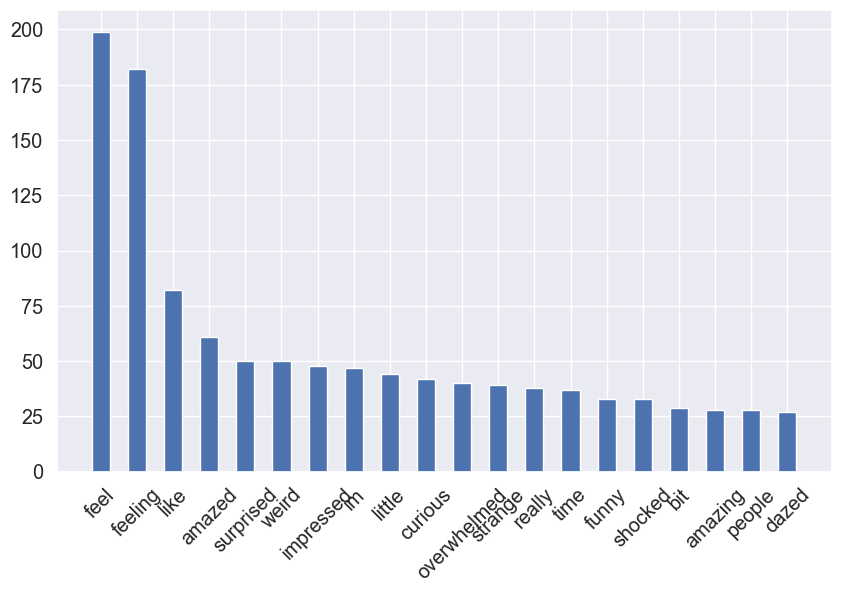

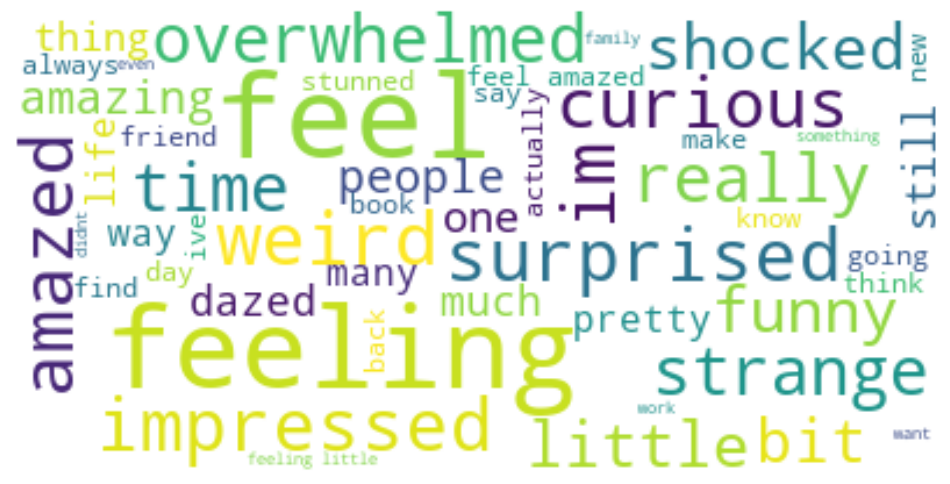

In [73]:
emotion_words(df_train, 'surprise')

On peut encore remarquer que malgrè les différentes émotions, la plupart des mots les plus fréquents sont les mêmes.
Ici, il y a '5350' lignes qui represente la 'joy' est que les mots les plus fréquents sont 'feel', 'feeling' et 'like'.
Et il y a '568' lignes qui represente la 'surprise' est que les mots les plus fréquents sont les mêmes que pour la 'joy'.

Et ceci est identique pour toutes les émotions.